In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import time
from requests.exceptions import ConnectionError
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

In [2]:
url = 'https://krisha.kz/prodazha/kvartiry/almaty-medeuskij/?page=1'
page = requests.get(url)
soup = BeautifulSoup(page.text, 'html')
pattern = r'\d+(?=\D*Дальше)'
filtr = r'[^0-9./]'

In [3]:
#First of all we should find the number of pages, in oder to get loop through them and get the data
pages = soup.find_all('nav', class_="paginator")
for page in pages:
    val = page.get_text(strip = True)
    match = re.search(pattern, val)
numPages = int(match.group())
numPages

199

In [4]:
#Here we loop through pages to get the all price data
all_prices = []
vals = []
val = []
session = requests.Session()
base_url = 'https://krisha.kz/prodazha/kvartiry/almaty-medeuskij/'
for pagenum in range(1,numPages//2):
    try:
        new_url = f'{base_url}?page={pagenum}'
        new_page = session.get(new_url)
        if new_page.status_code == 200:
          new_soup = BeautifulSoup(new_page.text, 'html.parser')
          # Extract prices
          prices = new_soup.find_all('div', class_='a-card__price')
          arr = [int(re.sub(r'\D', '', price.get_text(strip=True))) for price in prices]
          all_prices.extend(arr)

          # Extract info
          info = new_soup.find_all('div', class_="a-card__header-left")
          val = [re.sub(filtr, ' ',inf.get_text(strip=True, separator=',')) for inf in info]
          val = [va.split() for va in val]
          vals.extend(val)

        else:
          print(f"Error: Unable to fetch page {pagenum}. Status code: {new_page.status_code}")
          continue  # Move to the next page
    except ConnectionError as e:
      print(f"ConnectionError: {e}")
      time.sleep(5)  # Add a delay of 5 seconds before retrying
      continue  # Move to the next page

df = pd.DataFrame(vals,columns = ['Number of rooms', 'Area', 'Floor'])
df.insert(0, 'Price', all_prices)

df['Price'] = pd.to_numeric(df['Price'])
df['Number of rooms'] = pd.to_numeric(df['Number of rooms'])
print(df)


         Price  Number of rooms    Area Floor
0     30444000                3    70.8  None
1     56365000                3  112.73  None
2     18972000                1    52.7  None
3     45540000                1    50.6  None
4     37014800                1   60.68  None
...        ...              ...     ...   ...
1955  30000000                1      30   2/9
1956  30000000                1      40   3/9
1957  59000000                3      72   4/9
1958   8200000                1      21   1/3
1959  46500000                2      63   5/5

[1960 rows x 4 columns]


In [7]:
X = df.iloc[:,1:3]
Y = df.iloc[:, 0]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=1/3,random_state=42)
model = LinearRegression()
model.fit(X_train, Y_train)
result = model.score(X_test, Y_test)
y_pred = model.predict(X_test)
print("r^2: %.3f" % result)


r^2: 0.777


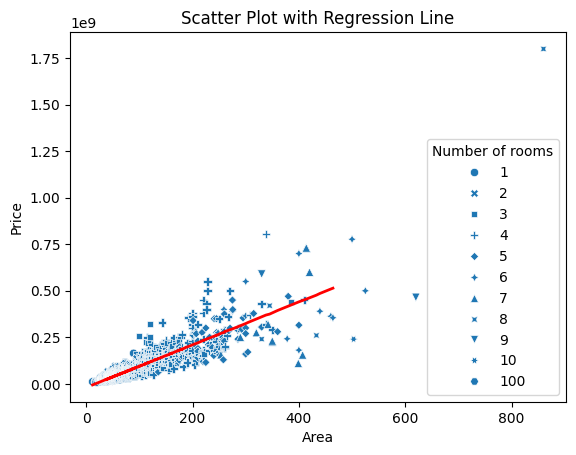

In [8]:
order = list('12345678')
df["Area"] = pd.to_numeric(df["Area"])
df_sorted = df.sort_values(by = 'Area')
X_test = X_test.sort_values(by = 'Area')
y_pred = model.predict(X_test)
def check_type(element):
    return type(element)

sns.scatterplot(data = df_sorted, x = 'Area', y = 'Price', style = 'Number of rooms', hue_order = order)

plt.plot(X_test['Area'], y_pred, color='red', linewidth=2, label='Regression Line (using predict)')
plt.title('Scatter Plot with Regression Line')
plt.show()
